#  AI Interest vs. AI Job Growth (Germany, USA, UK)

> **Research questions**
> 1. *Trend linkage:* Do public‑interest spikes in AI (Google Trends) align with growth in AI‑related job postings?
> 2. *Impact of ChatGPT:* How much has each country’s share of AI jobs changed since ChatGPT’s release on **30 Nov 2020**?


# Data Sources and Preparation

## Where I got the data:

- **Google Trends data:**  
  Retrieved daily “AI” interest scores for Germany, USA, and UK from [Google Trends](https://trends.google.com).  
  Exported as CSV 

- **AI Job Data:**  
  Collected from **Indeed’s** public job listings database, focusing on AI-related jobs by country and date.  
  Exported as CSV .

## Notes on data:

- The Google Trends interest scores range from 0 to 100 and reflect relative search interest.  
- The AI job data shows the percentage of job postings tagged with AI-related keywords out of total jobs for that day and country.  
- Data covers from January 2020 to March 2025.

---

## Why I used these sources

- Google Trends gives a proxy for public interest and awareness.  
- Indeed job data approximates actual market demand for AI skills.  
- Comparing them can reveal if interest and jobs move together or diverge.

---

## How I saved & loaded the data

- Both datasets were exported as CSV for ease of processing in Python and SQL.  
- Loaded in Python with `pd.read_csv()` 

---



#  Cleaning 

Goal: Clean data, drop na values

Main issue I had was the csv files and wrangling them into one df. Google trends only exports one country at a time. So what I did was merge the three csv files on AI intrests from google. I believe this caused me some problems later on.

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean

In [2]:
#importing the terms csv data obtained from the internet and creating Dataframe
Germany_interest= pd.DataFrame(pd.read_csv("Germany_interest.csv", header =1))
UK_interest= pd.DataFrame(pd.read_csv("UK_interest.csv", header =1))
USA_interest= pd.DataFrame(pd.read_csv("USA_interest.csv", header =1))

#Note, I had to learn what header was in this

In [3]:
#Cleaning up term datasets 
#drop NA from AI term 

Germany_interest.dropna(inplace=True)

#drop NA from Chat gpt terms
UK_interest.dropna(inplace=True)

#drop NA from USA interest
USA_interest.dropna(inplace=True)

Merging the AI interest df to work on sql 

In [4]:
#First 2 table merge
Combined_table  = pd.merge(Germany_interest, UK_interest, left_on='Week', right_on='Week')

#Final merged table
AI_interest= pd.merge(Combined_table, USA_interest, left_on='Week', right_on='Week')
AI_interest['Week']= pd.to_datetime(AI_interest['Week'])

In [5]:
#Rename columns
AI_interest.rename(columns={'ai: (Germany)':'Germany','ai: (United Kingdom)':'UK','ai: (United States)':'USA', 'Week':'Date'}, inplace=True)

In [6]:
#Importing ai jobs data
ai_job = pd.DataFrame(pd.read_csv("USA_UK_GERMANY_JOB AI.csv"))

Had some issues here with the column name '___typename'. There was a hidden blank somewhere making it hard to drop.

In [7]:
#dropping columns I don't need
ai_job.drop(columns=['__typename'], inplace=True)

In [8]:
#renaming columns
ai_job.rename(columns={'dateString':'Date', 'value':'percent_of_jobs'}, inplace=True)
ai_job_df = ai_job.groupby('Date').mean(numeric_only=True).reset_index()

# Connecting to MYSQL and exporting tables to query 

I wanted to work with SQL to answer my questions. I learned how to actually import queries into python directly instead of exporting each query as a CSV as I did in my previous project. 

In [9]:
#connecting to mySQL
from sqlalchemy import create_engine
# Your MySQL credentials
username = "root"        # e.g. "root"
password = "%Mail1226="        # e.g. "admin123"
host = "localhost"                # or IP address of remote server
port = "3306"                     # default MySQL port
database = "jobs_and_ai"   # e.g. "ai_project"

# Create engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

ai_job.to_sql("ai_jobs", con=engine, if_exists="replace", index=False)
AI_interest.to_sql("ai_interest", con=engine, if_exists="replace", index=False)

262

In [10]:
#Query from SQL

job_growth_vs_interest_query = """
SELECT 
	DISTINCT i.Date,
    percent_of_jobs,
    Germany,
    UK,
    USA
FROM ai_interest AS i
LEFT JOIN ai_jobs AS j ON j.Date = i.Date 
"""
job_percent_change_since_GPT_launch = """
WITH gpt_launch AS (SELECT 
date,
countryName,
percent_of_jobs
FROM ai_jobs
WHERE  date = '2020-11-30'),

gpt_current AS(SELECT 
date,
countryName,
percent_of_jobs
FROM ai_jobs
WHERE  date = '2025-03-30')


SELECT
  gpt_launch.countryName,
 (CASE
  WHEN gpt_current.countryName = 'Germany' THEN ROUND(((gpt_current.percent_of_jobs-gpt_launch.percent_of_jobs)/gpt_launch.percent_of_jobs) *100 , 1)
  WHEN gpt_current.countryName = 'United States' THEN ROUND(((gpt_current.percent_of_jobs-gpt_launch.percent_of_jobs)/gpt_launch.percent_of_jobs) *100 , 1)
   WHEN gpt_current.countryName = 'United Kingdom' THEN ROUND(((gpt_current.percent_of_jobs-gpt_launch.percent_of_jobs)/gpt_launch.percent_of_jobs) *100 , 1)
  END) AS Job_percent_change_since_GPT_launch
 FROM gpt_launch
 JOIN gpt_current ON gpt_launch.countryName = gpt_current.countryName

"""
#run queries and store in dataframe
corr_with_interest= pd.read_sql(job_growth_vs_interest_query, con=engine)
job_growth_since_gpt= pd.read_sql(job_percent_change_since_GPT_launch, con=engine)


#


##  Main project difficulty
By far the most difficult part in this project. I need to learn how to clean data on python better. I was having trouble because 3 identical dates were showing up and it was not plotting correctly. Also, the values were different. The google trend values were 0-100 and the Indeed data was in percentages. 

TLDR: I scaled different columns so they’re all on the same 0-to-1 scale, renamed them for clarity, and reshaped the data to plot it nicely.

In [11]:



#Normalizing the columns
orig_cols = ['percent_of_jobs', 'Germany', 'USA', 'UK']

#Scaling to 1 by dividing by each column's max value
norm = corr_with_interest[orig_cols].div(corr_with_interest[orig_cols].max(), axis=1)

#renaming normalized columns to avoid confusion
norm.columns = ['Percent_of_jobs_with_AI',
    'Germany_AI_interest',
    'USA_AI_Interest',
    'UK_AI_Interest']
#join normalized data to main data
corr = corr_with_interest.join(norm)

#REshape from wide to long so I could plot it better
long = corr.melt(
    id_vars='Date',                      
    value_vars= ['Percent_of_jobs_with_AI',
    'Germany_AI_interest',
    'USA_AI_Interest',
    'UK_AI_Interest'],
    var_name='series',
    value_name='value'
)


#  Results & visualisation 
## Line plot – AI interest vs. AI job share

C:\Users\dgil0\AppData\Local\Temp\ipykernel_33768\2806381899.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax=sns.lineplot(data=long, x='Date', y='value', hue='series', ci=None)


Text(2020-11-30 00:00:00, 0.2, 'Chat GPT released')

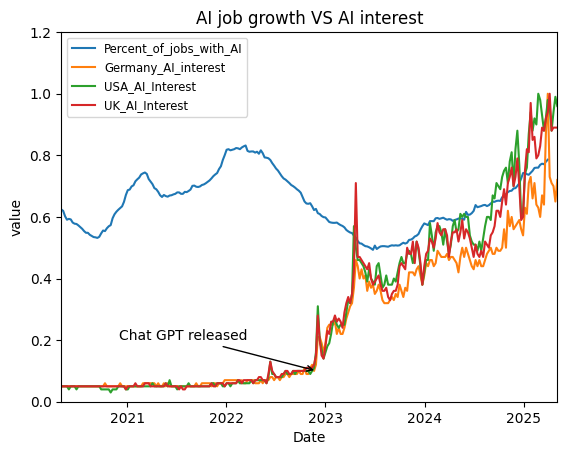

In [23]:
#Making first graph....I learned that I have to use ax when I'm using seaborn and want to use plt stuff

ax=sns.lineplot(data=long, x='Date', y='value', hue='series', ci=None)
ax.legend(fontsize ='small')
ax.set(ylim=(0, 1.2))  
ax.margins(x=0) 
ax.autoscale_view()  
ax.set_title('AI job growth VS AI interest')
release_date=pd.to_datetime("2022-11-30")
arrow_date=pd.to_datetime("2020-11-30")
ax.annotate(
"Chat GPT released",         # Text label
    xy=(release_date, 0.1),             # Point to annotate
    xytext=(arrow_date, .2),       # Text location
    arrowprops=dict(arrowstyle="->", color='black', lw=1.0))



## Bar plot – % change in AI jobs since ChatGPT

[Text(0, 0, '29.1%'), Text(0, 0, '16.6%'), Text(0, 0, '39.3%')]

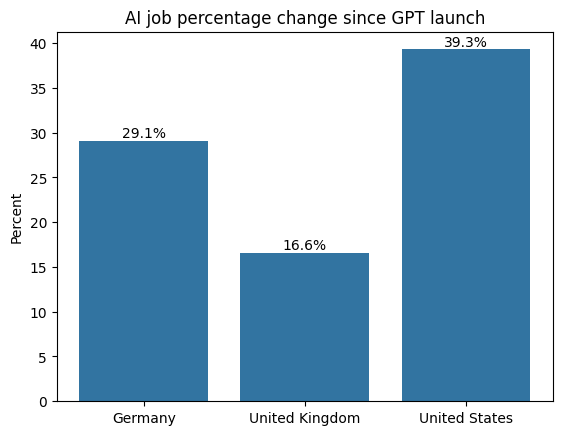

In [13]:
ax=sns.barplot(data=job_growth_since_gpt, x='countryName', y='Job_percent_change_since_GPT_launch', width=.8)
ax.autoscale_view()  
ax.set_title('AI job percentage change since GPT launch')
ax.set_xlabel('')
ax.set_ylabel('Percent')
#Learned the argument inside to place the label
ax.bar_label(ax.containers[0], fmt='%.1f%%')

# Discussion 

## Key insights:

- **Clear link between public interest and job growth:**  
  The data shows that the surge in AI-related public interest, as captured by Google Trends starting in early 2023 (shortly after ChatGPT's release), closely correlates with an increase in AI-related job postings in the USA, Germany, and the UK. This suggests that the rising enthusiasm for AI isn’t just hype—it’s reflected in actual labor market demand.

- **Different growth rates across countries:**  
  The USA leads with almost a 39% increase in AI job share since late 2020, followed by Germany at about 29%, and the UK at 16%. These differences could be influenced by several factors such as:
  - The size and maturity of each country's tech industry
  - Variation in how AI jobs are defined or tagged in job listings
  - Different economic or policy environments that affect AI adoption

- **Timing and trend patterns:**  
  From 2020 to 2022, AI interest and job growth were relatively stable or even declining. The significant upward trend in both series begins around early 2023, aligning well with the release and popularity of ChatGPT. This timing supports the idea that breakthroughs in AI technology can drive both public attention and market demand.

## Limitations and caveats:

- **Definition of AI jobs:**  
  The job data only includes roles explicitly tagged with AI-related keywords. Many positions that involve AI work but aren't labeled as such might be missing, potentially underestimating real AI job growth.

- **Google Trends limitations:**  
  Trends data reflect search interest but don’t capture all forms of AI awareness or engagement. Other signals, like social media or industry reports, might offer complementary insights.

- **Population differences:**  
  Differences in population size and workforce composition may partly explain why growth rates vary across countries. Normalizing by population or workforce size could refine these comparisons.

## What this means:

The combined analysis supports the conclusion that ChatGPT and similar AI innovations have had a tangible impact on both public interest and the job market in AI-related fields. Businesses seem to be responding by increasing AI job postings, indicating real demand for AI skills rather than just speculative excitement.




#  Reflection on the Project

I found this project quite challenging, especially because I worked with a lot of new Python concepts that I haven’t fully mastered yet. While data cleaning isn't my main focus, I realized I need to spend more time reviewing it to improve future projects.

My primary goal was to strengthen my SQL skills, and I’m proud of how well I did in that area. I asked clear questions and successfully answered them using SQL queries. One query I’m especially proud of is the one that calculates the percentage change in AI-related jobs since the launch of GPT:

```sql
WITH gpt_launch AS (
  SELECT date, countryName, percent_of_jobs
  FROM ai_jobs
  WHERE date = '2020-11-30'
),
gpt_current AS (
  SELECT date, countryName, percent_of_jobs
  FROM ai_jobs
  WHERE date = '2025-03-30'
)
SELECT
  gpt_launch.countryName,
  CASE
    WHEN gpt_current.countryName = 'Germany' THEN ROUND(((gpt_current.percent_of_jobs - gpt_launch.percent_of_jobs) / gpt_launch.percent_of_jobs) * 100, 1)
    WHEN gpt_current.countryName = 'United States' THEN ROUND(((gpt_current.percent_of_jobs - gpt_launch.percent_of_jobs) / gpt_launch.percent_of_jobs) * 100, 1)
    WHEN gpt_current.countryName = 'United Kingdom' THEN ROUND(((gpt_current.percent_of_jobs - gpt_launch.percent_of_jobs) / gpt_launch.percent_of_jobs) * 100, 1)
  END AS Job_percent_change_since_GPT_launch
FROM gpt_launch
JOIN gpt_current ON gpt_launch.countryName = gpt_current.countryName; 
```


Although there might be an easier way to write this query, it was frustrating at times but very rewarding once I figured it out. I relied heavily on online documentation and tried to apply everything I learned effectively.

Overall, I believe I can improve my workflow and coding style for future projects. This one took me about a week, starting on May 13th and finishing on May 19th.
